# ARIMA methods (Statistical)

# masalah seakrng check values yg sesuai untuk p,d,q 

### Notes: Covid19 dataset is seasonal 
1) visualise time series data 
2) make time series data stationary 
3) plot Autocorrelation and Correlation (ACF and PACF)
4) buiild ARIMA model
5) predicts using ARIMA model 

In [29]:
from calendar import month

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.core.pylabtools import figsize
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorboard.notebook import display, start
from pandas.tseries.offsets import DateOffset

missing values in dataset: 
date         0
cases_new    0
dtype: int64
length of dataset:  1716
date         datetime64[ns]
cases_new             int64
dtype: object
            count                           mean                  min  \
date         1716  2022-05-31 12:00:00.000000256  2020-01-25 00:00:00   
cases_new  1716.0                    3097.769814                  0.0   

                           25%                  50%                  75%  \
date       2021-03-28 18:00:00  2022-05-31 12:00:00  2023-08-03 06:00:00   
cases_new                131.0                851.5               3246.5   

                           max          std  
date       2024-10-05 00:00:00          NaN  
cases_new              33406.0  5621.640214  


<Axes: xlabel='date'>

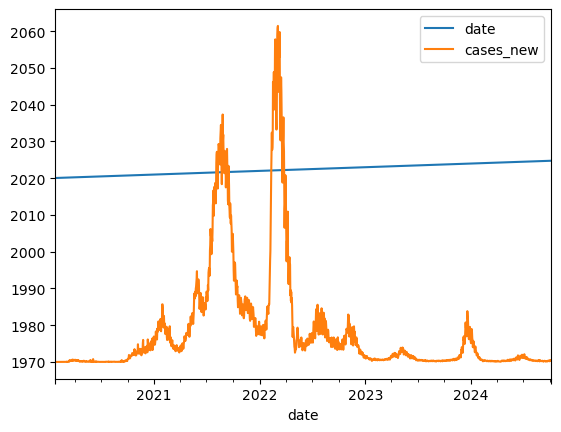

In [17]:
# Load the dataset
df = pd.read_csv('cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

# Set the frequency of the DataFrame's index to daily ('D')
df_grouped = df_grouped.asfreq('D')

# Check for missing values
print("missing values in dataset: ")
print( df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Check the length of the dataset
print("length of dataset: ", len(df_grouped))

#check df_grouped type of data for both columns
print(df_grouped.dtypes)

#calculate the mean,std, count, min, max, 25%,50%,75%
print (df_grouped.describe().transpose())
df_grouped.plot()



### Test the data is stationary or not 
#### Dickey fuller test
##### Notes:
1) if the data is stationary, then it is already good, however if the data is non stationary, then needs to to deferencing to the data to become stationary
2) stationary means the data has a constant mean, variance, and covarinace over time. 

In [18]:
result = adfuller(df_grouped['cases_new'])

def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky Fuller Test")
    labels = ['ADF Test Statistic', 'p-values', '# of lags', 'Num of Observations used']
    #p-values should be small to be stationary
    
    for value,label in zip(result,labels):
        print (label + ":" + str(value))
        
    if result[1] <= 0.5:
        print ("Strong evidence against null hypothesis")
        print ('reject null hypothesis')
        print ("Data has no unit root and is stationary")
    else: 
        print("weak evidence against null hypothesis")
        print('fail to reject null hypothesis')
        print("Data has an unit root and is non-stationary")
        
adf_check(df_grouped['cases_new'])


Augmented Dicky Fuller Test
ADF Test Statistic:-4.325283659131318
p-values:0.00040149894121822
# of lags:22
Num of Observations used:1693
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


Augmented Dicky Fuller Test
ADF Test Statistic:-6.919481603526019
p-values:1.1563454362010727e-09
# of lags:25
Num of Observations used:1678
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


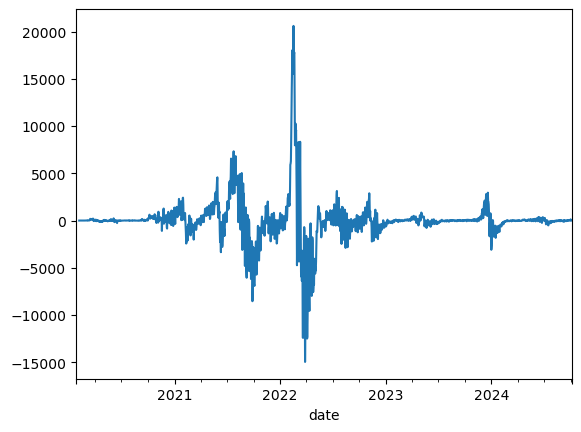

In [19]:
#Seasonal Differencing, trying to see if data is stationary by seasonal time or not
df_grouped['Seasonal Difference'] = df_grouped['cases_new'] - df_grouped['cases_new'].shift(12)
df_grouped['Seasonal Difference'].plot()
adf_check(df_grouped['Seasonal Difference'].dropna()) #dropna because we shift the data and remove one row


### Plot Autocorrelation and Partial Autocorrelation


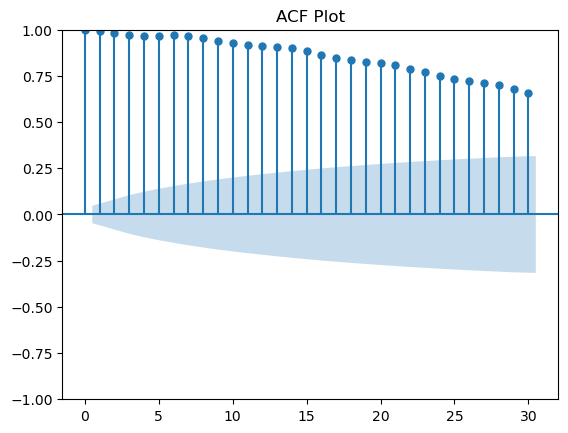

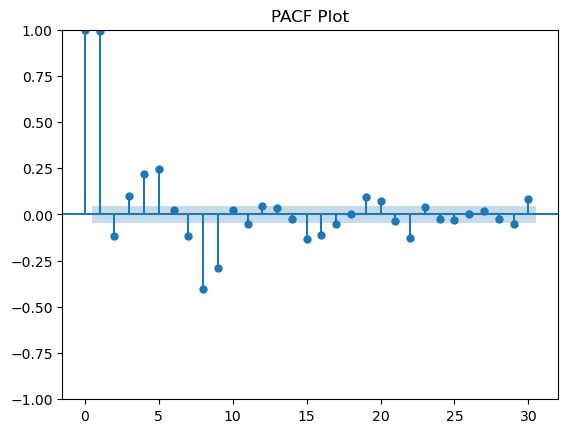

In [20]:
# #Autocorrelation
# fig_first = plot_acf(df_grouped['cases_new']) #sharp drop off
# fig_seasonal_first = plot_acf(df_grouped['Seasonal Difference'].dropna()) #gradual decline 
# 
# #Partial Auto correlation
# result = plot_pacf(df_grouped['Seasonal Difference'].dropna())

# Plot ACF and PACF
plot_acf(df_grouped['cases_new'], lags=30)
plt.title('ACF Plot')
plt.show()

plot_pacf(df_grouped['cases_new'], lags=30)
plt.title('PACF Plot')
plt.show()


## Predicts using ARIMA model 
### Data Preprocessing (sort data, split the data) and build ARIMA

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07498D+00    |proj g|=  2.76643D-01

At iterate    5    f=  9.01704D+00    |proj g|=  4.68576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   9.890D-06   9.017D+00
  F =   9.0170445398570429     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                 SARIMAX Results                                  
Dep. Variable:                  cases_new   No. O

<Axes: ylabel='Density'>

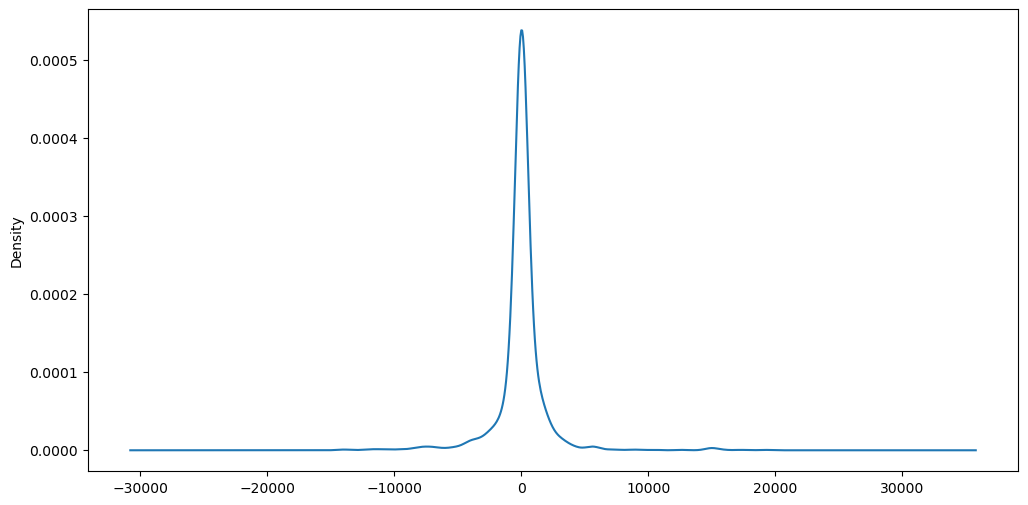

In [27]:
#Build Arima with Udemy 
#Choose the values of p and q based on the acf and pacf

#strong seasonal pattern, might increase p and q

#These values imply that: in order and seasonal order values 
# No autoregressive terms (p=0)
# Differencing (d=1)
# No moving average terms (q=0)
# Seasonal autoregressive terms (P=1)
# Seasonal differencing (D=1)
# Seasonal moving average terms (Q=1)
# Seasonal period (s=12, which implies yearly seasonality if your data is daily)

# try:
#     model = sm.tsa.statespace.SARIMAX(df_grouped['cases_new'],order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False) #try toggle the data ,change the values of p,d,q to resolve the unconstrained problem
#     results = model.fit()
#     print(results.summary())
#     results.resid.plot(kind= 'kde')
# except Exception as e:
#     print("Error fitting model: " + e)

model = sm.tsa.statespace.SARIMAX(df_grouped['cases_new'],order=(0,0,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

# residual values has the error based off what it would predict for all original data
# results.resid
# results.resid.plot()
results.resid.plot(kind= 'kde')



                 date  cases_new  Seasonal Difference   forecast
date                                                            
2024-10-01 2024-10-01        193                124.0  56.417371
2024-10-02 2024-10-02         99                 34.0  94.501054
2024-10-03 2024-10-03        140                 57.0  78.133932
2024-10-04 2024-10-04        119                 64.0  44.014361
2024-10-05 2024-10-05        112                 24.0  84.038854


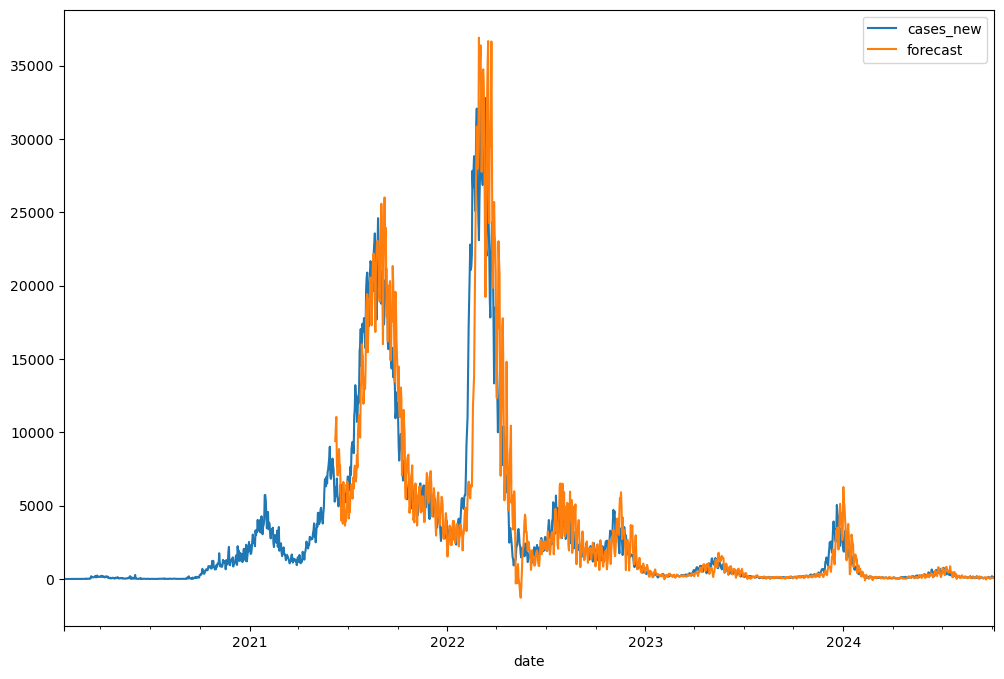

In [28]:
df_grouped['forecast'] = results.predict(start='2022-01-01', end='2024-10-03')
df_grouped[['cases_new', 'forecast']].plot(figsize(12,8))
print(df_grouped.tail())

In [53]:
#forecast new values that is the dates is not in the data 
#create a new date in that has 365 days (starting from first day)
future_dates = [df_grouped.index[-1] + DateOffset(days=x) for x in range (1,365)] 
future_dates

[Timestamp('2024-10-06 00:00:00'),
 Timestamp('2024-10-07 00:00:00'),
 Timestamp('2024-10-08 00:00:00'),
 Timestamp('2024-10-09 00:00:00'),
 Timestamp('2024-10-10 00:00:00'),
 Timestamp('2024-10-11 00:00:00'),
 Timestamp('2024-10-12 00:00:00'),
 Timestamp('2024-10-13 00:00:00'),
 Timestamp('2024-10-14 00:00:00'),
 Timestamp('2024-10-15 00:00:00'),
 Timestamp('2024-10-16 00:00:00'),
 Timestamp('2024-10-17 00:00:00'),
 Timestamp('2024-10-18 00:00:00'),
 Timestamp('2024-10-19 00:00:00'),
 Timestamp('2024-10-20 00:00:00'),
 Timestamp('2024-10-21 00:00:00'),
 Timestamp('2024-10-22 00:00:00'),
 Timestamp('2024-10-23 00:00:00'),
 Timestamp('2024-10-24 00:00:00'),
 Timestamp('2024-10-25 00:00:00'),
 Timestamp('2024-10-26 00:00:00'),
 Timestamp('2024-10-27 00:00:00'),
 Timestamp('2024-10-28 00:00:00'),
 Timestamp('2024-10-29 00:00:00'),
 Timestamp('2024-10-30 00:00:00'),
 Timestamp('2024-10-31 00:00:00'),
 Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-11-02 00:00:00'),
 Timestamp('2024-11-

<Axes: >

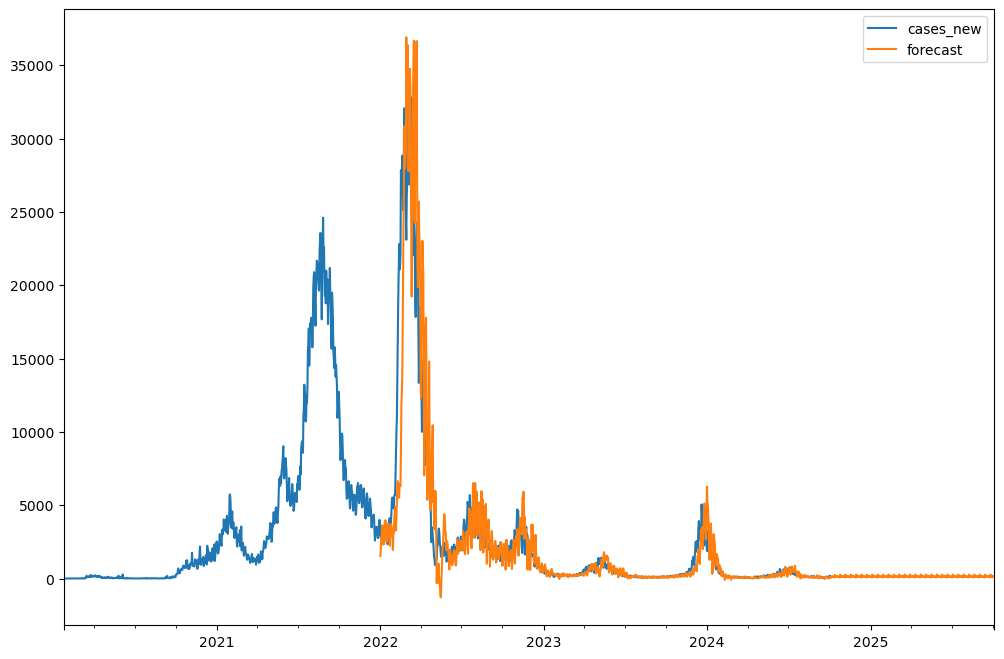

In [58]:
future_df = pd.DataFrame(index=future_dates, columns= df_grouped.columns) #create the same columns that have in df_grouped
final_df = pd.concat([df_grouped, future_df]) #combine both data frame (df_grouped and future_df)
final_df['forecast'] = results.predict(start='2022-01-01', end='2025-10-04') #predict forecast from 1000 until 2000
final_df[['cases_new','forecast']].plot(figsize(12,8)) #plot both the actual cases and the forecast cases 